## 3a_Analysis notebook

Project: clustering-analysis-domain-agnostic-features-2018

Authors: Jordan Perr-Sauer, Caleb Phillips

License: BSD 3-Clause

Copyright (c) 2021 Alliance for Sustainable Energy LLC

## Description

This notebook uses the features extracted from notebooks 2a and 2b and performes a clustering analysis, generating Figures 3,4,5 and 6 in the technical report.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
from tqdm import tqdm
matplotlib.style.use('ggplot')
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import sklearn

In [2]:
display(sklearn.__version__)
display(matplotlib.__version__)
display(sns.__version__)
display(pd.__version__)
display(sklearn.__version__)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12}) 

'0.20.0'

'2.2.3'

'0.9.0'

u'0.20.3'

'0.20.0'

# Load features from CSV

In [4]:
import pandas as pd

features_traditional = pd.read_csv("./data/FleetDNAETL_CoDA_epaprime_traditional_nolimit.public.csv").set_index("vdir").sort_index()
features_agnostic = pd.read_csv("./data/FleetDNAETL_CoDA_epaprime_agnostic_50klimit.public.csv").set_index("vdir").sort_index()

cols = [x for x in features_agnostic.columns if x[0]=='s']
features_agnostic_speed = features_agnostic[cols]

display( features_traditional.head() )
display( features_agnostic_speed.head() )
features_agnostic = features_agnostic_speed

,avg_driving_speed,max_speed,percent_zero,driving_speed_standard_deviation,ca_standard,as_standard,percent_distance_below_55,stops_per_mile
vdir,,,,,,,,
0,30.111234,53.546818,51.011562,15.334193,0.356364,58.806602,72.618999,3.406476
1,19.054442,36.152151,42.739844,8.894907,0.637276,35.992490,100.000000,5.649696
2,15.823089,29.519268,63.892418,8.256701,0.566539,31.481721,91.604425,18.499014
3,12.935747,41.554911,89.205873,11.838133,0.452976,38.534565,91.459959,8.052635
4,21.774640,41.848719,73.538261,11.217034,2.206808,42.430710,88.058762,8.313654


,speed__ratio_beyond_r_sigma__r_1.5,"speed__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","speed__fft_coefficient__coeff_2__attr_""real""",speed__symmetry_looking__r_0.7,"speed__fft_coefficient__coeff_19__attr_""angle""","speed__fft_coefficient__coeff_41__attr_""abs""","speed__fft_coefficient__coeff_83__attr_""angle""","speed__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""slope""","speed__fft_coefficient__coeff_47__attr_""abs""","speed__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10",...,speed__ratio_beyond_r_sigma__r_2,"speed__fft_coefficient__coeff_50__attr_""abs""","speed__fft_coefficient__coeff_84__attr_""real""","speed__fft_coefficient__coeff_37__attr_""abs""","speed__fft_coefficient__coeff_89__attr_""imag""","speed__fft_coefficient__coeff_31__attr_""imag""","speed__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.8","speed__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""",speed__number_crossing_m__m_1,"speed__fft_coefficient__coeff_66__attr_""real"""
vdir,,,,,,,,,,,,,,,,,,,,,
0,0.539701,0.595729,0.258717,0.922078,0.467430,0.000000,0.503681,0.659189,0.000000,0.659984,...,0.392601,0.000000,0.753641,0.000000,0.564901,0.675994,0.0,0.000000,0.030944,0.704354
1,0.471074,0.633727,0.250580,0.920455,0.467430,0.000000,0.503681,0.651215,0.000000,0.372439,...,0.244872,0.000000,0.753641,0.000000,0.564901,0.675994,0.0,0.000000,0.035915,0.704354
2,0.526861,0.132980,0.255260,0.935961,0.470043,0.006241,0.490139,0.588102,0.005218,0.356556,...,0.562057,0.004860,0.754274,0.005137,0.564901,0.674955,0.0,0.411442,0.007128,0.705255
3,0.566708,0.454859,0.217460,1.000000,0.237150,0.468120,0.719314,0.658481,0.312368,0.659984,...,0.902574,0.828401,0.331667,0.282986,0.968997,0.540526,0.0,0.292595,0.849383,0.159251
4,0.489323,0.595729,0.282316,0.820513,0.467430,0.000000,0.503681,0.633019,0.000000,0.596946,...,0.532393,0.000000,0.753641,0.000000,0.564901,0.675994,0.0,0.000000,0.021368,0.704354


# Preprocessing

Normalize features using min-max scaling

In [5]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

X_traditional_1 = normalize(features_traditional).dropna(axis=1)
X_agnostic_1 = normalize(features_agnostic).dropna(axis=1)
X_agnostic_1 = X_agnostic_1.reindex_axis(sorted(X_agnostic_1.columns), axis=1)

Remove highly correlated features from Agnostic features

In [6]:
corr_matrix = X_agnostic_1.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_agnostic = X_agnostic_1.drop(to_drop, axis=1)

X_traditional = X_traditional_1

In [7]:
print "Agnostic: Keep {} of {} features. {}%".format(X_agnostic.shape[1], X_agnostic_1.shape[1], ((X_agnostic.shape[1]+0.0)/X_agnostic_1.shape[1]) * 100)

Agnostic: Keep 421 of 723 features. 58.2295988935%


# Visualization

Plot data using PCA

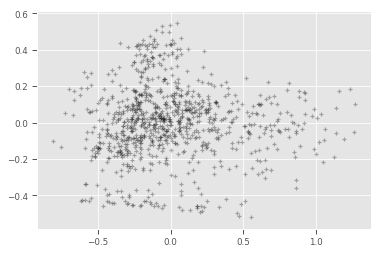

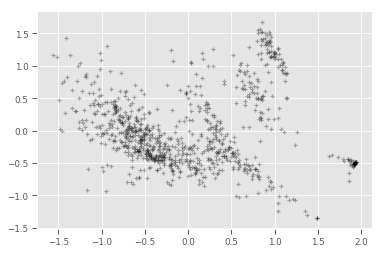

In [8]:
pca = PCA(n_components=2, whiten=False)

Y_pca_traditional = pca.fit_transform(X_traditional)
Y_pca_traditional_df = pd.DataFrame(Y_pca_traditional).set_index(X_traditional.index)

plt.scatter(Y_pca_traditional[:,0], Y_pca_traditional[:,1], color="black", marker="+", alpha=0.3)
plt.show()

Y_pca_agnostic = pca.fit_transform(X_agnostic)
Y_pca_agnostic_df = pd.DataFrame(Y_pca_agnostic).set_index(X_agnostic.index)

plt.scatter(Y_pca_agnostic_df[0], Y_pca_agnostic_df[1], color="black", marker="+", alpha=0.3)
plt.show()

# KMeans Visualization
Features are now stored in X_agnostic, X_traditional

In [9]:
def clusters(alg, data, index):
    C = alg.fit_predict(data)
    return pd.DataFrame(C).set_index(index)

def make_scatterplot(projection, coloring, palette="Set1", marker="+"):
    PC = projection.copy()
    PC["color"] = coloring
    g = sns.lmplot(x="0", y="1", data=PC.rename(columns=lambda x: str(x)), height=5, palette = palette, fit_reg=False, hue='color', legend=False, markers=marker, scatter_kws={"alpha":0.8})
    g.set(xticklabels=[], yticklabels=[])
    g.set_axis_labels("PC 1", "PC 2")
    return g

In [10]:
from sklearn.cluster import KMeans

# Before reduction
C_traditional_kmeans_df = clusters(KMeans(n_clusters=3), X_traditional, features_traditional.index)
C_agnostic_kmeans_df = clusters(KMeans(n_clusters=3), X_agnostic, features_agnostic.index)

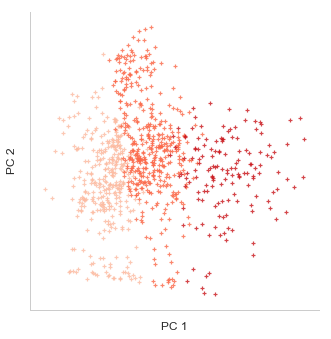

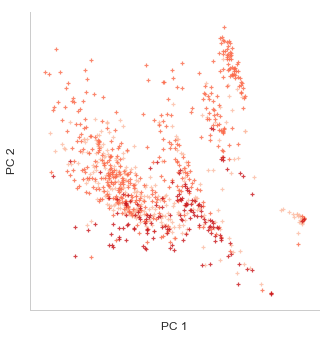

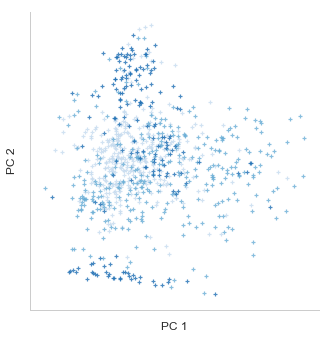

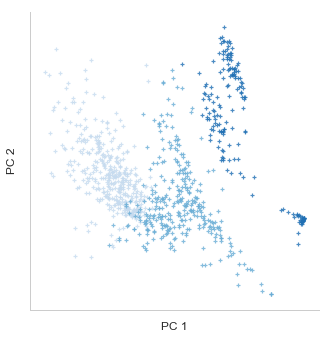

In [11]:
# "#9b4545", "#509b45", "#45459b"
# "#459b99", "#8f459b", "#8f9b45"

sns.set_style("whitegrid", {'axes.grid' : False})
make_scatterplot(Y_pca_traditional_df, C_traditional_kmeans_df, "Reds", "+").savefig("./paper_figs/proj_TradPCA_color_TradKM.eps")
make_scatterplot(Y_pca_agnostic_df, C_traditional_kmeans_df, "Reds", "+").savefig("./paper_figs/proj_AgnosticPCA_color_TradKM.eps")
make_scatterplot(Y_pca_traditional_df, C_agnostic_kmeans_df, "Blues", "+").savefig("./paper_figs/proj_TradPCA_color_AgnosticKM.eps")
make_scatterplot(Y_pca_agnostic_df, C_agnostic_kmeans_df, "Blues", "+").savefig("./paper_figs/proj_AgnosticPCA_color_AgnosticKM.eps")

# Silhouette Score for various K-Means N

In [12]:
from sklearn.metrics import silhouette_score

df = pd.DataFrame({"Number of Clusters":[], "Silhouette Score":[], "Feature Set":[]})
feat_dict = {"Domain Specific":Y_pca_traditional_df, "Domain Agnostic":Y_pca_agnostic_df}

# If you don't do PCA first, there are issues with the differenct number of dimensions for each domain.
#feat_dict = {"Domain Specific":X_traditional, "Domain Agnostic":X_agnostic}


for features_label in tqdm(["Domain Specific", "Domain Agnostic"]):
    features = feat_dict[features_label]
    feat_index = {"Domain Specific":features_traditional.index, "Domain Agnostic":features_agnostic.index}[features_label]
    for n in range(2,15):
        c = clusters(KMeans(n_clusters=n), features, feat_index)
        silhouette = silhouette_score(features, c)
        tmp_df = pd.DataFrame({"Number of Clusters":[n], "Silhouette Score":[silhouette], "Feature Set":[features_label]})
        df = df.append(tmp_df)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/jperrsau/opt/anaconda3/envs/clustering_analysis_env/lib/python2.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


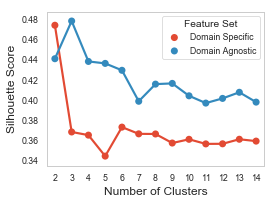

In [13]:
fig = plt.figure(figsize=(4,3))

sns.pointplot(x="Number of Clusters", y="Silhouette Score", hue="Feature Set", data=df)

fig.axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, num: int(num+2)))
plt.tight_layout()
fig.savefig("./paper_figs/sillhouette_plot.eps")


# Silhouette Score for Varying Number of Agnostic Features

In [14]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

from sklearn.metrics import silhouette_score

df = pd.DataFrame({"Number of Features":[], "Silhouette Score":[]})
feat_dict = {"Domain Specific":Y_pca_traditional_df, "Domain Agnostic":Y_pca_agnostic_df}

# If you don't do PCA first, there are issues with the differenct number of dimensions for each domain.
#feat_dict = {"Domain Specific":X_traditional, "Domain Agnostic":X_agnostic}
np.random.seed(2018)
possible_features = list(X_agnostic.columns)

#x_labels= range(8,428,10)
x_labels= range(8,428,10)

for num_features in tqdm(x_labels):
    for sample_number in range(25):
        feature_names = np.random.choice(possible_features, num_features, False)
        subset_features = X_agnostic[feature_names]
        
        pca = PCA(n_components=2, whiten=False)
        subset_pca = pca.fit_transform(subset_features)
        subset_pca_df = pd.DataFrame(subset_pca).set_index(subset_features.index)
        
        c = clusters(KMeans(n_clusters=3), subset_pca_df, subset_pca_df.index)
        silhouette = silhouette_score(subset_pca_df, c)
        
        tmp_df = pd.DataFrame({"Number of Features":[num_features], "Silhouette Score":[silhouette]})
        df = df.append(tmp_df)

100%|██████████| 42/42 [01:02<00:00,  1.50s/it]


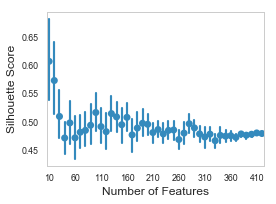

In [15]:
import matplotlib.ticker as ticker
x_labels = range(10,428,20)
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(4,3))
sns.pointplot(x="Number of Features", y="Silhouette Score", data=df, join=False, pallete="muted", color="C1")
fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda val, num: int(10+10*val)))
plt.xticks()
plt.tight_layout()
fig.savefig("./paper_figs/Silhoutte_Num_Features.eps")

# Density of Agnostic Cluster Centroids - Vary # Of Features

In [16]:
from sklearn import preprocessing
from tqdm import tqdm
import random

plotting_df = features_traditional.copy()

def centroids_for(C):
    plotting_df["LABEL"] = C
    return plotting_df.dropna().groupby("LABEL").mean()

centroid_agn_smol = None

for n in range(2,5):
    for n_features in tqdm(range(2,12)):
        for samples in range(50):
            these_features = random.sample(list(X_agnostic.columns), n_features)
            c_a = centroids_for(clusters(KMeans(n_clusters=n), X_agnostic[these_features], features_agnostic.index))
            if centroid_agn_smol is None:
                centroid_agn_smol = c_a
            else:
                centroid_agn_smol = centroid_agn_smol.append(c_a)

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


In [17]:
centroid_agn = None

for n in range(2,5):
    for n_features in tqdm(range(50,60)):
        for samples in range(50):
            these_features = random.sample(list(X_agnostic.columns), n_features)
            c_a = centroids_for(clusters(KMeans(n_clusters=n), X_agnostic[these_features], features_agnostic.index))
            if centroid_agn is None:
                centroid_agn = c_a
            else:
                centroid_agn = centroid_agn.append(c_a)

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


In [18]:
trad_centroids = features_traditional.join( C_traditional_kmeans_df ).groupby(0).mean()
agno_centroids = features_traditional.join( C_agnostic_kmeans_df ).groupby(0).mean()

<Figure size 288x216 with 0 Axes>

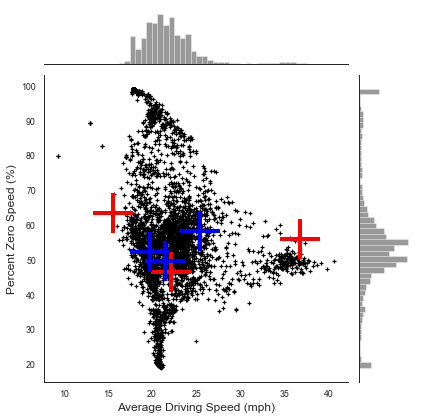

In [19]:
fig = plt.figure(figsize=(4,3))
with sns.axes_style("white"):
    h = sns.jointplot(x="avg_driving_speed", y="percent_zero", data=centroid_agn, color="k", marker="+", stat_func=None)
    h.set_axis_labels('Average Driving Speed (mph)', 'Percent Zero Speed (%)')
    h.ax_joint.plot(trad_centroids["avg_driving_speed"],trad_centroids["percent_zero"], linestyle = 'None', marker='+', markersize=40,mew=4, color="red")
    h.ax_joint.plot(agno_centroids["avg_driving_speed"],agno_centroids["percent_zero"], linestyle = 'None', marker='+', markersize=40,mew=4, color="blue")
    h.savefig("./paper_figs/hexbin_large_features.eps")